In [26]:
# Looking into correlations given all data

import pandas as pd
import numpy as np

file_path = '../../data/processed/cleaned_properties.csv'
df = pd.read_csv(file_path)

# Select numeric columns (excluding location columns)
numeric_cols = [col for col in df.select_dtypes(include='number').columns
                if col not in ['zip_code', 'latitude', 'longitude', 'missing_count']]

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Flatten the matrix, keep only one triangle (no duplicates)
corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Sort by absolute correlation descending
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()
corr_pairs_sorted = corr_pairs.sort_values('abs_corr', ascending=False).drop(columns='abs_corr')

# Display
display(corr_pairs_sorted)


Feature 1                       Feature 2  \
21                            price                    nbr_bedrooms   
117                      fl_terrace                     terrace_sqm   
50                   total_area_sqm                    nbr_bedrooms   
33                construction_year                  total_area_sqm   
18                            price                  total_area_sqm   
..                              ...                             ...   
12                               id                fl_swimming_pool   
140                      garden_sqm  primary_energy_consumption_sqm   
151  primary_energy_consumption_sqm                cadastral_income   
74                 surface_land_sqm                cadastral_income   
15                               id               fl_double_glazing   

     Correlation  
21      0.352444  
117     0.296247  
50      0.222688  
33     -0.214476  
18      0.199648  
..           ...  
12     -0.000368  
140    -0.000265  
151    -0.000241  
74      0.000192  
15      0.000096  

[153 rows x 3 columns]

In [27]:
# Adapting to not look at outliers:

import pandas as pd
import numpy as np

file_path = '../../data/processed/cleaned_properties.csv'
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# Step 1: Select numeric columns (excluding certain ones)
# -------------------------------------------------------------------
numeric_cols = [col for col in df.select_dtypes(include='number').columns
                if col not in ['zip_code', 'latitude', 'longitude', 'missing_count']]

# -------------------------------------------------------------------
# Step 2: Remove outliers (trim 5% lowest and 5% highest for each column)
# -------------------------------------------------------------------
df_trimmed = df.copy()

for col in numeric_cols:
    lower = df[col].quantile(0.05)
    upper = df[col].quantile(0.95)
    df_trimmed[col] = df[col].clip(lower=lower, upper=upper)

# -------------------------------------------------------------------
# Step 3: Compute correlation matrix on trimmed data
# -------------------------------------------------------------------
corr_matrix = df_trimmed[numeric_cols].corr()

# -------------------------------------------------------------------
# Step 4: Flatten the matrix (keep only one triangle)
# -------------------------------------------------------------------
corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# -------------------------------------------------------------------
# Step 5: Sort by absolute correlation descending
# -------------------------------------------------------------------
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()
corr_pairs_sorted = corr_pairs.sort_values('abs_corr', ascending=False).drop(columns='abs_corr')

# -------------------------------------------------------------------
# Step 6: Display results
# -------------------------------------------------------------------
display(corr_pairs_sorted)



/var/folders/87/3rmswg3n0_b52bj0cbkjgwjw0000gn/T/ipykernel_10346/227882990.py:23: FutureWarning:

Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Feature 1          Feature 2  Correlation
105       fl_garden         garden_sqm     0.752864
44   total_area_sqm       nbr_bedrooms     0.728502
92       fl_terrace        terrace_sqm     0.709732
28            price   cadastral_income     0.660974
16            price     total_area_sqm     0.591209
..              ...                ...          ...
3                id   surface_land_sqm    -0.001112
0                id              price     0.000713
15            price  construction_year    -0.000677
14               id   cadastral_income    -0.000392
13               id  fl_double_glazing     0.000031

[120 rows x 3 columns]

In [28]:
# Removing the logical correlations between fl_garden and fl_terrace and their areas

import pandas as pd
import numpy as np

file_path = '../../data/processed/cleaned_properties.csv'
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# Step 1: Select numeric columns (excluding certain ones)
# -------------------------------------------------------------------
numeric_cols = [col for col in df.select_dtypes(include='number').columns
                if col not in ['zip_code', 'latitude', 'longitude', 'missing_count']]

# -------------------------------------------------------------------
# Step 2: Remove outliers (clip 5–95%)
# -------------------------------------------------------------------
df_trimmed = df.copy()
for col in numeric_cols:
    lower = df[col].quantile(0.05)
    upper = df[col].quantile(0.95)
    df_trimmed[col] = df[col].clip(lower=lower, upper=upper)

# -------------------------------------------------------------------
# Step 3: Compute correlation matrix
# -------------------------------------------------------------------
corr_matrix = df_trimmed[numeric_cols].corr()

# -------------------------------------------------------------------
# Step 4: Flatten the matrix (upper triangle)
# -------------------------------------------------------------------
corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# -------------------------------------------------------------------
# Step 5: Remove only the expected flag/value correlations
# -------------------------------------------------------------------
flag_links = {
    'fl_terrace': 'terrace_sqm',
    'fl_garden': 'garden_sqm'
}

# Exclude only the direct flag/value pair
def is_expected_flag_pair(row):
    return (row['Feature 1'], row['Feature 2']) in flag_links.items() or \
           (row['Feature 2'], row['Feature 1']) in flag_links.items()

corr_pairs_filtered = corr_pairs[~corr_pairs.apply(is_expected_flag_pair, axis=1)]

# -------------------------------------------------------------------
# Step 6: Sort by absolute correlation descending
# -------------------------------------------------------------------
corr_pairs_filtered['abs_corr'] = corr_pairs_filtered['Correlation'].abs()
corr_pairs_sorted = corr_pairs_filtered.sort_values('abs_corr', ascending=False).drop(columns='abs_corr')

# -------------------------------------------------------------------
# Step 7: Display results
# -------------------------------------------------------------------
display(corr_pairs_sorted)


/var/folders/87/3rmswg3n0_b52bj0cbkjgwjw0000gn/T/ipykernel_10346/2604308127.py:22: FutureWarning:

Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/87/3rmswg3n0_b52bj0cbkjgwjw0000gn/T/ipykernel_10346/2604308127.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Feature 1                       Feature 2  Correlation
44     total_area_sqm                    nbr_bedrooms     0.728502
28              price                cadastral_income     0.660974
16              price                  total_area_sqm     0.591209
54   surface_land_sqm                   nbr_frontages     0.569734
39  construction_year  primary_energy_consumption_sqm    -0.569118
..                ...                             ...          ...
3                  id                surface_land_sqm    -0.001112
0                  id                           price     0.000713
15              price               construction_year    -0.000677
14                 id                cadastral_income    -0.000392
13                 id               fl_double_glazing     0.000031

[118 rows x 3 columns]

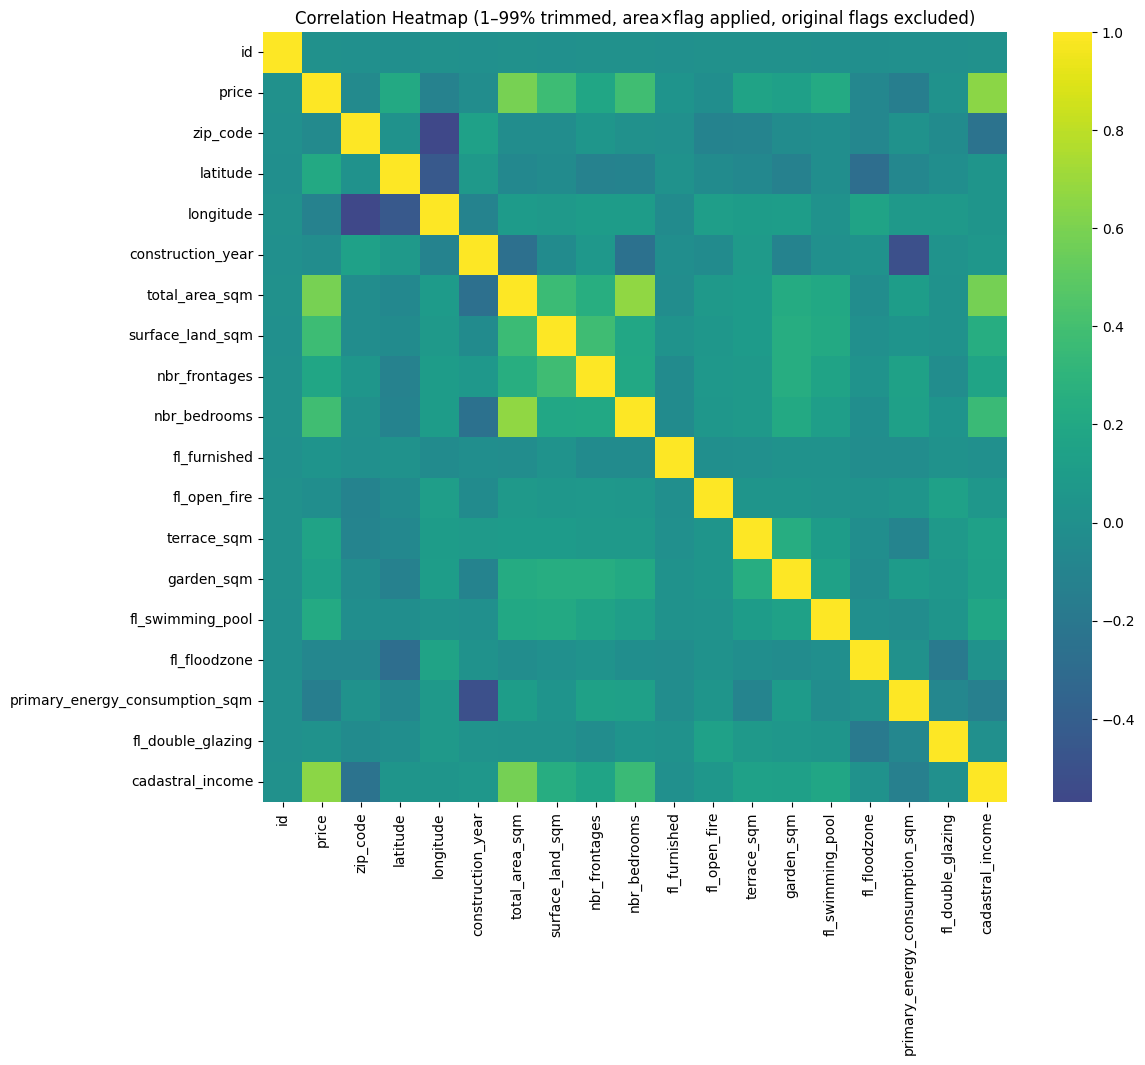

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Step 0: Load data
# -------------------------------------------------------------------
file_path = '../../data/processed/cleaned_properties.csv'
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# Step 1: Define flag/area pairs and apply area*flag
# -------------------------------------------------------------------
flag_links = {
    'fl_terrace': 'terrace_sqm',
    'fl_garden': 'garden_sqm'
}

df_processed = df.copy()
for flag, area in flag_links.items():
    if flag in df_processed.columns and area in df_processed.columns:
        # Multiply area by flag → area is 0 if flag=0
        df_processed[area] = df_processed[area].fillna(0) * df_processed[flag].fillna(0)

# -------------------------------------------------------------------
# Step 2: Identify numeric columns
# -------------------------------------------------------------------
numeric_cols = df_processed.select_dtypes(include='number').columns.tolist()

# Exclude the flags that were used to adjust areas
flags_to_exclude = list(flag_links.keys())
numeric_cols_for_corr = [col for col in numeric_cols if col not in flags_to_exclude]

# Identify binary flags among remaining numeric columns
binary_flags = [col for col in numeric_cols_for_corr 
                if df_processed[col].dropna().isin([0,1]).all()]

# Continuous numeric columns (to trim 1–99%)
continuous_cols = [col for col in numeric_cols_for_corr if col not in binary_flags]

# -------------------------------------------------------------------
# Step 3: Trim continuous columns (exclude flags)
# -------------------------------------------------------------------
df_trimmed = df_processed.copy()
for col in continuous_cols:
    lower = df_trimmed[col].quantile(0.01)
    upper = df_trimmed[col].quantile(0.99)
    df_trimmed[col] = df_trimmed[col].clip(lower=lower, upper=upper)

# -------------------------------------------------------------------
# Step 4: Compute correlation matrix (exclude original flags)
# -------------------------------------------------------------------
corr_matrix = df_trimmed[numeric_cols_for_corr].corr()

# -------------------------------------------------------------------
# Step 5: Display heatmap
# -------------------------------------------------------------------
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap="viridis", center=0)
plt.title('Correlation Heatmap (1–99% trimmed, area×flag applied, original flags excluded)')
plt.show()


In [30]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "vscode"  # VS Code native renderer
pio.renderers.default = "notebook_connected"

# Load data
file_path = '../../data/processed/cleaned_properties.csv'
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# Step 1: Trim price outliers (1-99%)
# -------------------------------------------------------------------
if 'price' in df.columns:
    lower_price = df['price'].quantile(0.01)
    upper_price = df['price'].quantile(0.99)
    df['price'] = df['price'].clip(lower=lower_price, upper=upper_price)

# -------------------------------------------------------------------
# Step 2: Filter properties within Belgium (lat/lon bounding box)
# -------------------------------------------------------------------
lat_min, lat_max = 49.5, 51.5
lon_min, lon_max = 2.5, 6.5

df_belgium = df[
    (df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
    (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)
].copy()

print(f"Number of properties in Belgium: {len(df_belgium)}")

# -------------------------------------------------------------------
# Step 3: Plot map
# -------------------------------------------------------------------
fig = px.scatter_map(
    df_belgium,
    lat="latitude",
    lon="longitude",
    color="price",
    zoom=7,
    color_continuous_scale="Viridis",
    hover_data=['price', 'total_area_sqm', 'nbr_bedrooms']  # optional
)
fig.show()



Number of properties in Belgium: 61401


In [31]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "vscode"  # VS Code native renderer
pio.renderers.default = "notebook_connected"

# Load data
file_path = '../../data/processed/cleaned_properties.csv'
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# Step 1: Trim price outliers (5-95%)
# -------------------------------------------------------------------
if 'price' in df.columns:
    lower_price = df['price'].quantile(0.05)
    upper_price = df['price'].quantile(0.95)
    df['price'] = df['price'].clip(lower=lower_price, upper=upper_price)

# -------------------------------------------------------------------
# Step 2: Filter properties within Belgium (lat/lon bounding box)
# -------------------------------------------------------------------
lat_min, lat_max = 49.5, 51.5
lon_min, lon_max = 2.5, 6.5

df_belgium = df[
    (df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
    (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)
].copy()

print(f"Number of properties in Belgium: {len(df_belgium)}")

# -------------------------------------------------------------------
# Step 3: Plot map
# -------------------------------------------------------------------
fig = px.scatter_map(
    df_belgium,
    lat="latitude",
    lon="longitude",
    color="price",
    zoom=7,
    color_continuous_scale="Viridis",
    hover_data=['price', 'total_area_sqm', 'nbr_bedrooms']  # optional
)
fig.show()



Number of properties in Belgium: 61401


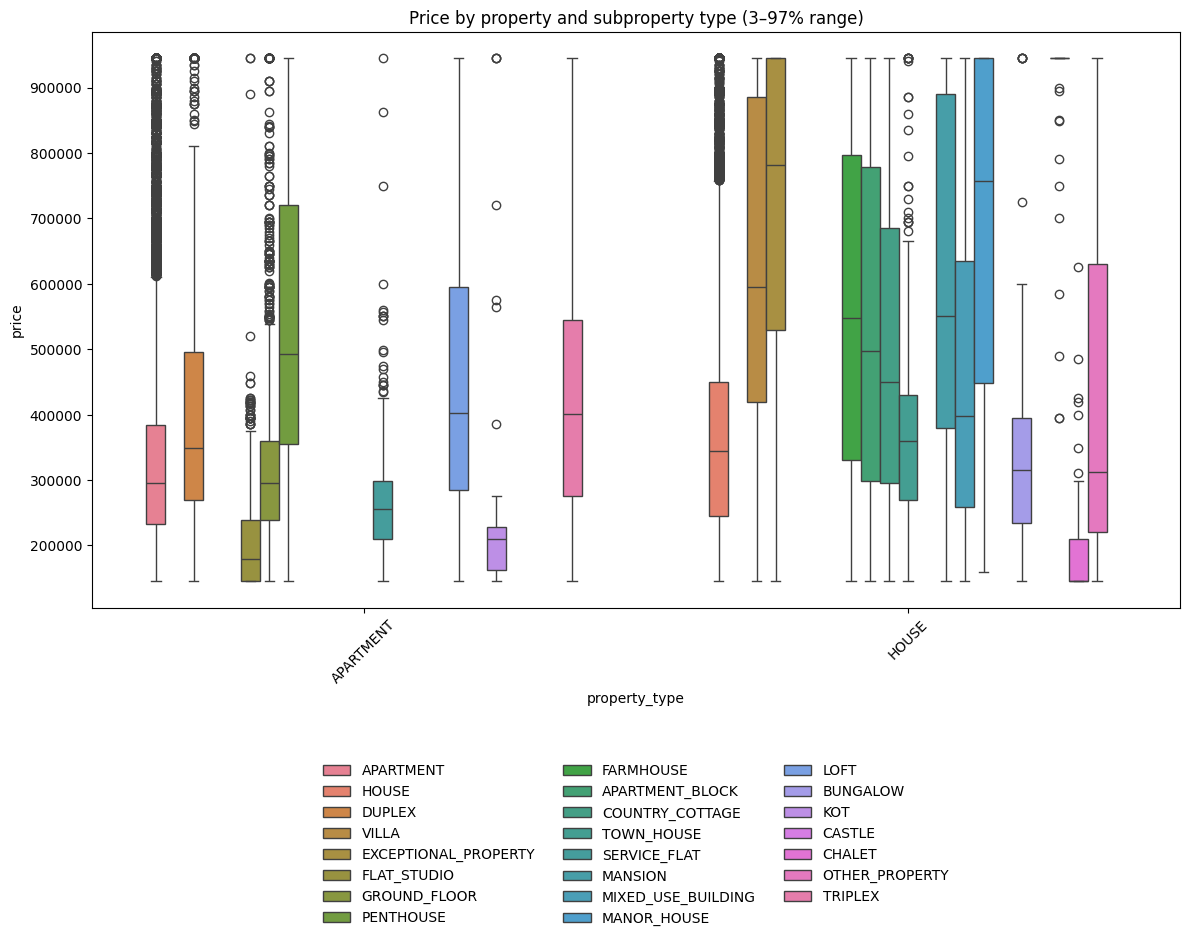

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already loaded
# -------------------------------------------------------------------
# Step 1: Trim price to 3–97% percentile to remove outliers
# -------------------------------------------------------------------
lower_price = df['price'].quantile(0.03)
upper_price = df['price'].quantile(0.97)

df_trimmed = df.copy()
df_trimmed['price'] = df_trimmed['price'].clip(lower=lower_price, upper=upper_price)

# -------------------------------------------------------------------
# Step 2: Boxplot per property/subproperty type
# -------------------------------------------------------------------
plt.figure(figsize=(12,10))
sns.boxplot(
    data=df_trimmed,
    x="property_type",
    y="price",
    hue="subproperty_type"
)
plt.xticks(rotation=45)
plt.title("Price by property and subproperty type (3–97% range)")

# Move legend to bottom and wrap to multiple rows
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,  # pick number of columns per row
    frameon=False
)

plt.tight_layout()
plt.show()


/var/folders/87/3rmswg3n0_b52bj0cbkjgwjw0000gn/T/ipykernel_10346/3193117757.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




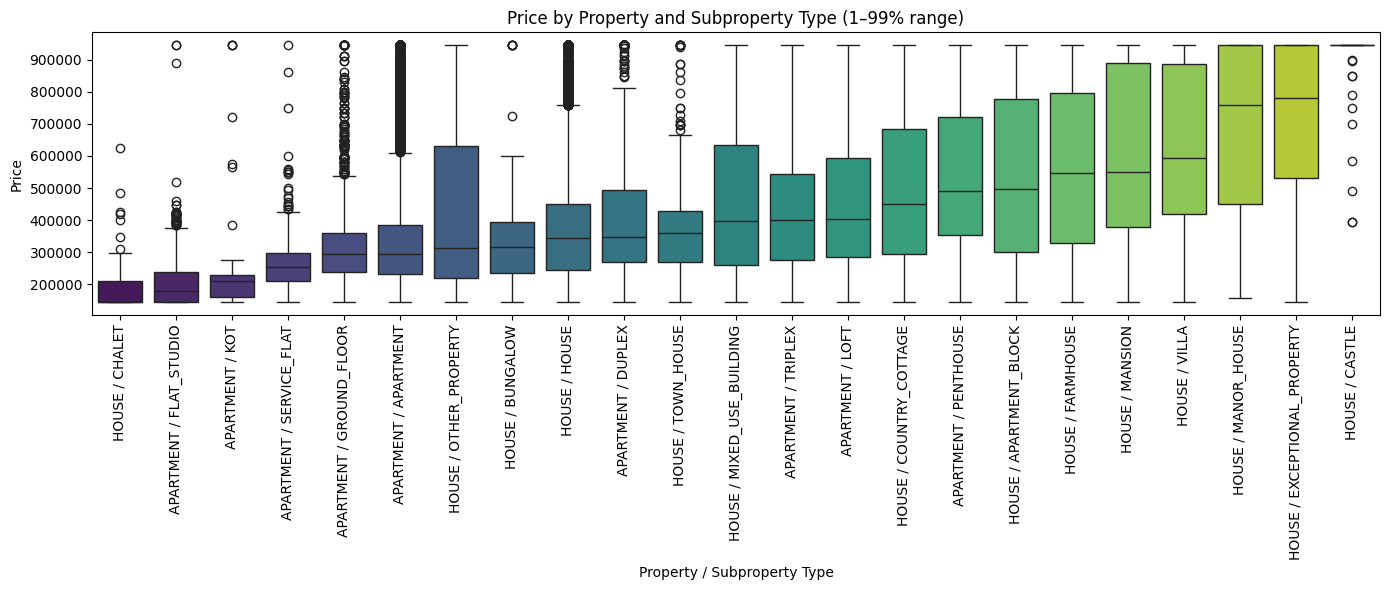

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Trim price to 3–97% percentile
lower_price = df['price'].quantile(0.01)
upper_price = df['price'].quantile(0.99)

df_trimmed = df.copy()
df_trimmed['price'] = df_trimmed['price'].clip(lower=lower_price, upper=upper_price)

# Step 2: Create combined label for x-axis
df_trimmed['property_subtype'] = df_trimmed['property_type'] + " / " + df_trimmed['subproperty_type']

# Step 3: Sort by median price
median_prices = df_trimmed.groupby('property_subtype')['price'].median().sort_values()
sorted_categories = median_prices.index.tolist()

# Step 4: Plot
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df_trimmed,
    x='property_subtype',
    y='price',
    order=sorted_categories,          # ensures sorted order
    palette='viridis'                 # color coding
)

plt.xticks(rotation=90)
plt.title("Price by Property and Subproperty Type (1–99% range)")
plt.xlabel("Property / Subproperty Type")
plt.ylabel("Price")

plt.tight_layout()
plt.show()


/var/folders/87/3rmswg3n0_b52bj0cbkjgwjw0000gn/T/ipykernel_10346/1341432681.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




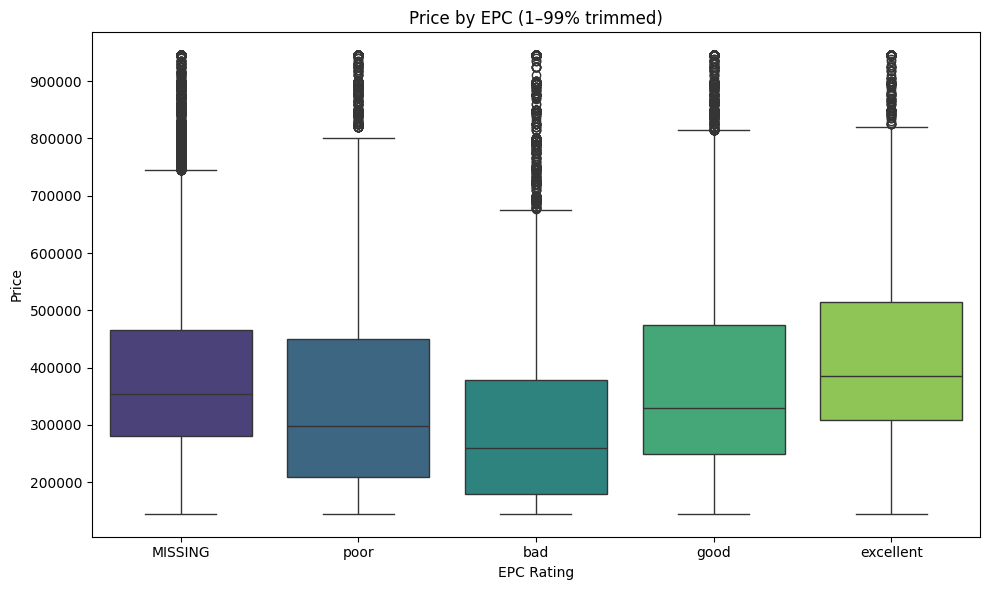

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Trim price to 1–99% percentile to remove extreme outliers
lower_price = df['price'].quantile(0.01)
upper_price = df['price'].quantile(0.99)

df_trimmed = df.copy()
df_trimmed['price'] = df_trimmed['price'].clip(lower=lower_price, upper=upper_price)

# Step 2: Define custom order for EPC (or any categorical column)
epc_order = ['MISSING', 'poor', 'bad', 'good', 'excellent']

# Step 3: Convert EPC column to ordered categorical
df_trimmed['epc'] = pd.Categorical(df_trimmed['epc'], categories=epc_order, ordered=True)

# Step 4: Boxplot with ordered categories
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_trimmed,
    x='epc',
    y='price',
    palette='viridis'
)

plt.title("Price by EPC (1–99% trimmed)")
plt.xlabel("EPC Rating")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


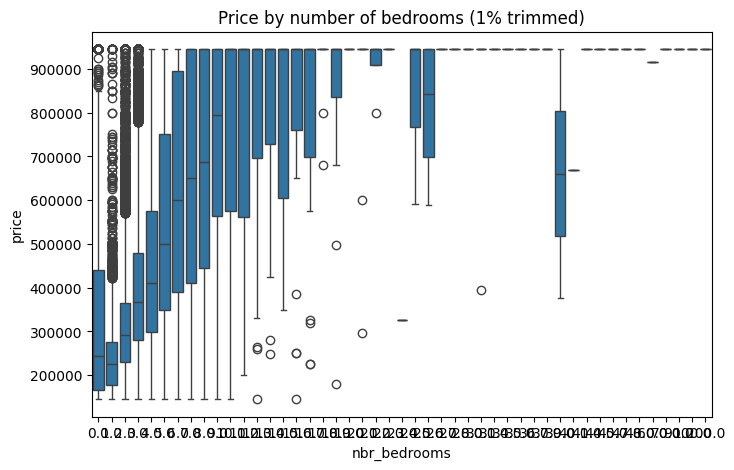

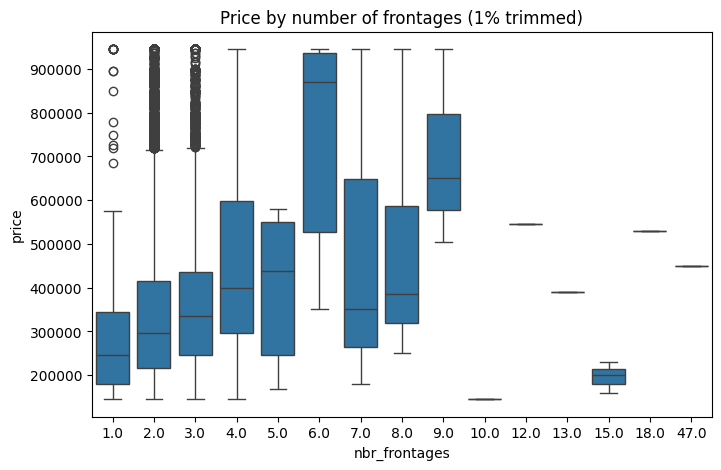

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate 1st and 99th percentiles
lower = df['price'].quantile(0.01)
upper = df['price'].quantile(0.99)

# Filter dataframe
df_filtered = df[(df['price'] >= lower) & (df['price'] <= upper)]

# Boxplot: Bedrooms vs Price
plt.figure(figsize=(8,5))
sns.boxplot(data=df_filtered, x="nbr_bedrooms", y="price")
plt.title("Price by number of bedrooms (1% trimmed)")
plt.show()

# Boxplot: Frontages vs Price
plt.figure(figsize=(8,5))
sns.boxplot(data=df_filtered, x="nbr_frontages", y="price")
plt.title("Price by number of frontages (1% trimmed)")
plt.show()


In [36]:
import pandas as pd

# Assuming your dataframe is df and price is numeric
numeric_cols = df.select_dtypes(include='number').columns

# Compute correlations
corr_matrix = df[numeric_cols].corr()

# Extract correlations with price and sort descending
price_corr = corr_matrix['price'].sort_values(ascending=False)

print("Features most correlated with price:")
print(price_corr)


Features most correlated with price:
price                             1.000000
nbr_bedrooms                      0.363741
nbr_frontages                     0.212446
latitude                          0.203358
fl_swimming_pool                  0.182554
total_area_sqm                    0.177915
terrace_sqm                       0.132116
surface_land_sqm                  0.124213
garden_sqm                        0.087116
fl_garden                         0.060987
fl_terrace                        0.045578
fl_double_glazing                 0.022408
fl_furnished                      0.013545
cadastral_income                  0.002066
id                                0.000833
primary_energy_consumption_sqm   -0.001529
construction_year                -0.005243
fl_open_fire                     -0.012879
zip_code                         -0.072426
fl_floodzone                     -0.085101
longitude                        -0.093199
Name: price, dtype: float64


In [37]:
import pandas as pd

# Calculate 1st and 99th percentile of price
lower = df['price'].quantile(0.01)
upper = df['price'].quantile(0.99)

# Filter dataframe to keep only prices within 1%-99%
df_filtered = df[(df['price'] >= lower) & (df['price'] <= upper)]

# Select numeric columns
numeric_cols = df_filtered.select_dtypes(include='number').columns

# Compute correlations
corr_matrix = df_filtered[numeric_cols].corr()

# Extract correlations with price and sort
price_corr = corr_matrix['price'].sort_values(ascending=False)

print("Features most correlated with price (1%-99% range):")
print(price_corr)


Features most correlated with price (1%-99% range):
price                             1.000000
nbr_bedrooms                      0.363741
nbr_frontages                     0.212446
latitude                          0.203358
fl_swimming_pool                  0.182554
total_area_sqm                    0.177915
terrace_sqm                       0.132116
surface_land_sqm                  0.124213
garden_sqm                        0.087116
fl_garden                         0.060987
fl_terrace                        0.045578
fl_double_glazing                 0.022408
fl_furnished                      0.013545
cadastral_income                  0.002066
id                                0.000833
primary_energy_consumption_sqm   -0.001529
construction_year                -0.005243
fl_open_fire                     -0.012879
zip_code                         -0.072426
fl_floodzone                     -0.085101
longitude                        -0.093199
Name: price, dtype: float64


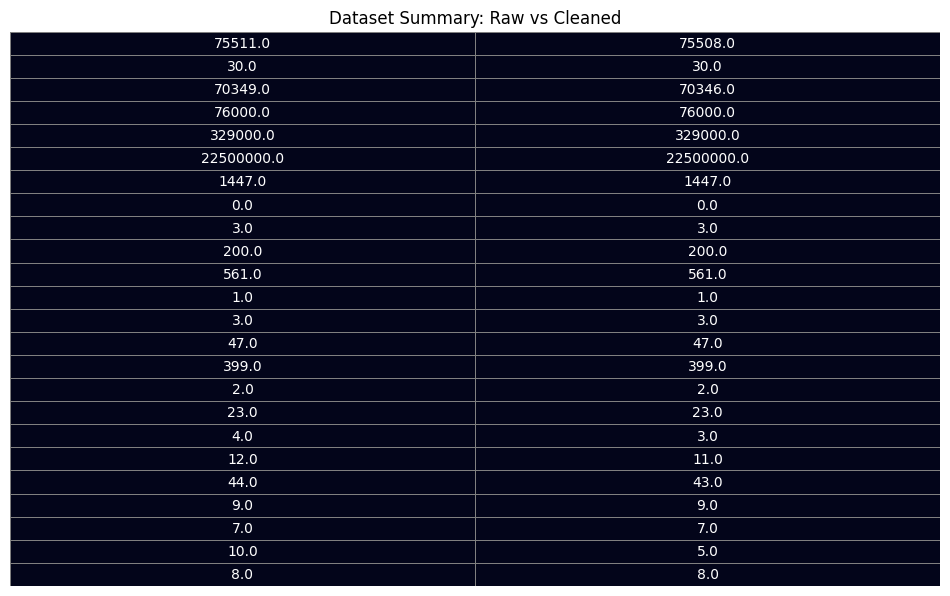

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_raw = pd.read_csv("../../data/raw/immoweb_data.csv")
df_clean = pd.read_csv("../../data/processed/cleaned_properties.csv")

# Define numeric and categorical columns to summarize
numeric_cols = ['price', 'nbr_bedrooms', 'nbr_frontages']
cat_cols = df_raw.select_dtypes(include='object').columns.tolist()

# Helper function to create summary dataframe
def create_summary(df, label):
    summary = {}
    summary['Rows'] = df.shape[0]
    summary['Columns'] = df.shape[1]
    summary['Rows with missing'] = df.isna().any(axis=1).sum()
    
    for col in numeric_cols:
        summary[f"{col} min"] = df[col].min()
        summary[f"{col} median"] = df[col].median()
        summary[f"{col} max"] = df[col].max()
        summary[f"{col} 1% outliers"] = ((df[col] < df[col].quantile(0.01)) | 
                                          (df[col] > df[col].quantile(0.99))).sum()
    
    for col in cat_cols:
        summary[f"{col} unique"] = df[col].nunique()
    
    return pd.DataFrame(summary, index=[label]).T

# Create summary tables
raw_summary = create_summary(df_raw, 'Raw')
clean_summary = create_summary(df_clean, 'Cleaned')

# Merge for side-by-side comparison
comparison = pd.concat([raw_summary, clean_summary], axis=1)
comparison.columns = ['Raw Data', 'Cleaned Data']

# Visualize as a colourful table
plt.figure(figsize=(12, max(6, comparison.shape[0]*0.3)))
sns.heatmap(pd.isna(comparison), cbar=False, annot=comparison, fmt='', linewidths=.5, linecolor='gray')
plt.title("Dataset Summary: Raw vs Cleaned")
plt.axis('off')
plt.show()


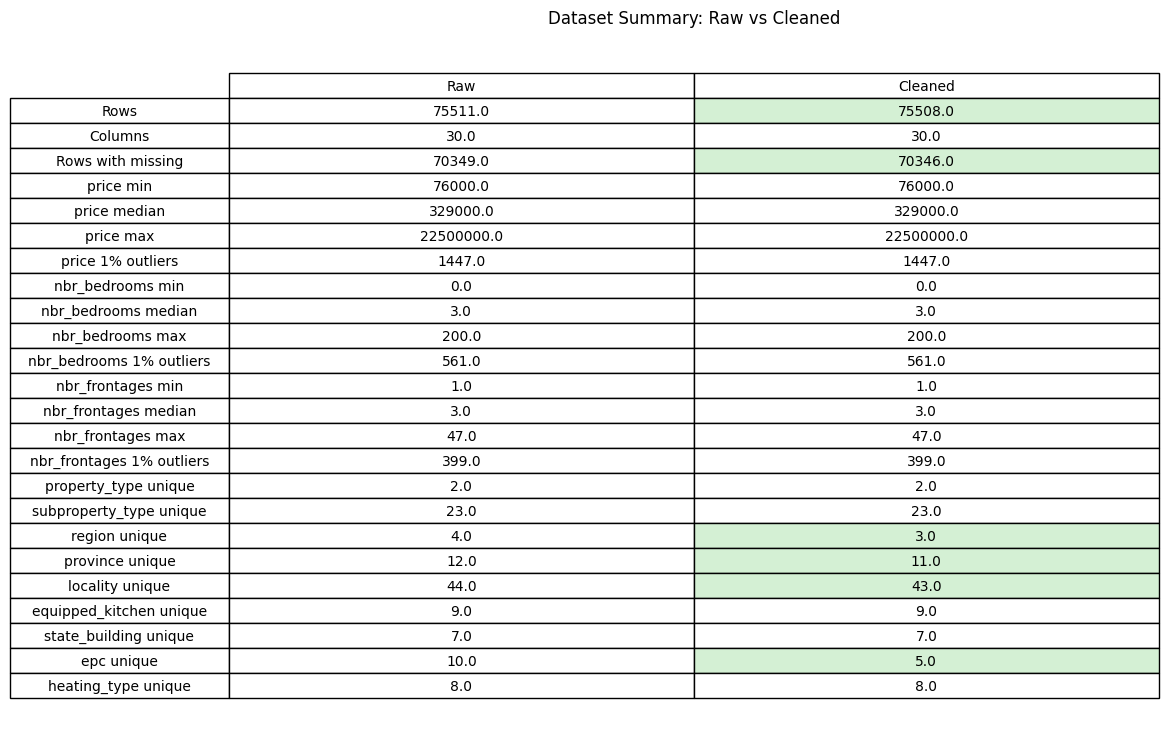

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine raw and cleaned summaries (reuse create_summary logic)
comparison = pd.concat([raw_summary, clean_summary], axis=1)
comparison.columns = ['Raw', 'Cleaned']

# Plot as a table
fig, ax = plt.subplots(figsize=(12, len(comparison)*0.3 + 2))
ax.axis('off')
tbl = ax.table(cellText=comparison.values,
               rowLabels=comparison.index,
               colLabels=comparison.columns,
               cellLoc='center',
               rowLoc='center',
               loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)  # adjust height

# Optional: color improvements
for i, row in enumerate(comparison.values):
    raw_val, clean_val = row
    for j, val in enumerate(row):
        cell = tbl[i+1, j]  # +1 because header row
        if j == 1:  # Cleaned column
            if clean_val < raw_val:
                cell.set_facecolor('#d4f0d4')  # green
            elif clean_val > raw_val:
                cell.set_facecolor('#f0d4d4')  # red

plt.title("Dataset Summary: Raw vs Cleaned")
plt.show()


In [40]:
import pandas as pd

# Load datasets
df_raw = pd.read_csv("../../data/raw/immoweb_data.csv")
df_clean = pd.read_csv("../../data/processed/cleaned_properties.csv")

numeric_cols = ['price', 'nbr_bedrooms', 'nbr_frontages']  # adjust as needed

comparison = []

for col in numeric_cols:
    raw_mean = df_raw[col].mean()
    clean_mean = df_clean[col].mean()
    factor = clean_mean / raw_mean if raw_mean != 0 else None
    comparison.append({
        'Column': col,
        'Raw mean': raw_mean,
        'Cleaned mean': clean_mean,
        'Factor (Cleaned / Raw)': factor
    })

comparison_df = pd.DataFrame(comparison)
print(comparison_df)


          Column       Raw mean   Cleaned mean  Factor (Cleaned / Raw)
0          price  422770.850737  422772.960613                1.000005
1   nbr_bedrooms       2.787276       2.787321                1.000016
2  nbr_frontages       2.802929       2.802978                1.000017


=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75508 entries, 0 to 75507
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              75508 non-null  int64  
 1   price                           75508 non-null  float64
 2   property_type                   75508 non-null  object 
 3   subproperty_type                75508 non-null  object 
 4   region                          75505 non-null  object 
 5   province                        75505 non-null  object 
 6   locality                        75505 non-null  object 
 7   zip_code                        75508 non-null  int64  
 8   latitude                        61410 non-null  float64
 9   longitude                       61410 non-null  float64
 10  construction_year               42120 non-null  float64
 11  total_area_sqm                  67893 non-null  float64
 12  surface_l

cadastral_income                  44964
surface_land_sqm                  36253
construction_year                 33388
primary_energy_consumption_sqm    26566
nbr_frontages                     26346
longitude                         14098
latitude                          14098
terrace_sqm                       13140
total_area_sqm                     7615
garden_sqm                         2939
province                              3
region                                3
locality                              3
price                                 0
zip_code                              0
id                                    0
subproperty_type                      0
property_type                         0
fl_open_fire                          0
fl_furnished                          0
nbr_bedrooms                          0
equipped_kitchen                      0
fl_garden                             0
fl_terrace                            0
fl_floodzone                          0



=== Percentage of missing values per column ===


cadastral_income                  59.548657
surface_land_sqm                  48.012131
construction_year                 44.217831
primary_energy_consumption_sqm    35.183027
nbr_frontages                     34.891667
longitude                         18.670869
latitude                          18.670869
terrace_sqm                       17.402130
total_area_sqm                    10.085024
garden_sqm                         3.892303
province                           0.003973
region                             0.003973
locality                           0.003973
price                              0.000000
zip_code                           0.000000
id                                 0.000000
subproperty_type                   0.000000
property_type                      0.000000
fl_open_fire                       0.000000
fl_furnished                       0.000000
nbr_bedrooms                       0.000000
equipped_kitchen                   0.000000
fl_garden                       

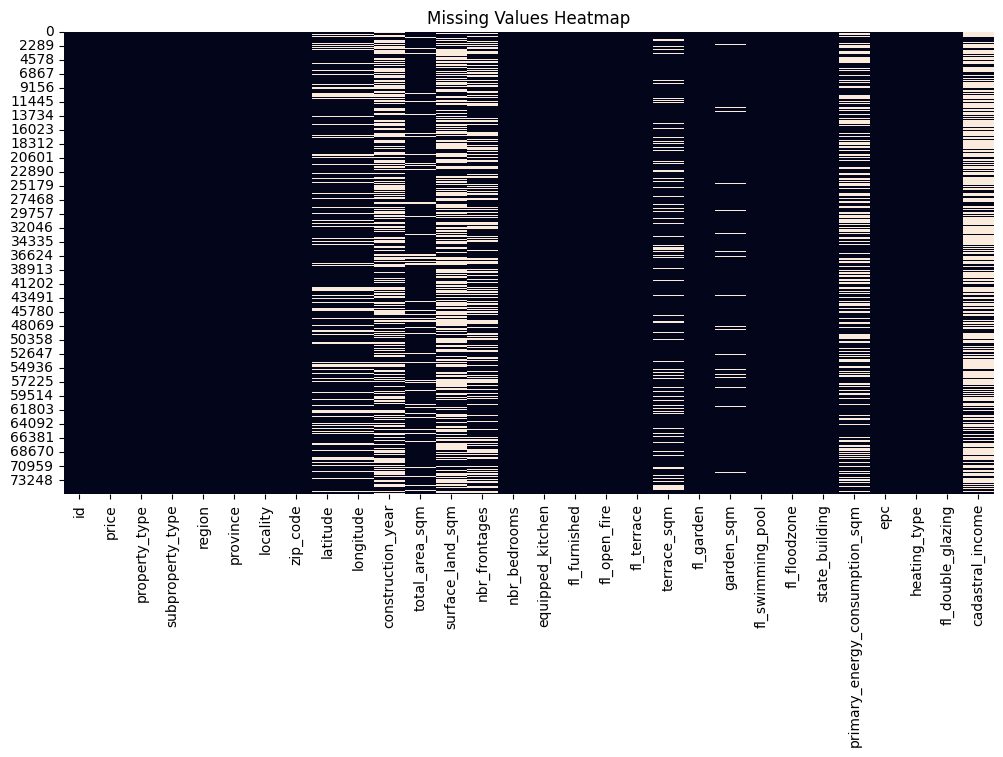


Rows with highest missing counts:


id     price property_type subproperty_type            region  \
52163  16170000  216500.0     APARTMENT      FLAT_STUDIO               NaN   
63127  47220000  509500.0     APARTMENT        PENTHOUSE               NaN   
70522   8671000  199900.0     APARTMENT        APARTMENT          Flanders   
22838  41635000  129000.0     APARTMENT      FLAT_STUDIO          Flanders   
865    65561000  367288.0     APARTMENT        APARTMENT  Brussels-Capital   
17312  78920000  150000.0     APARTMENT        APARTMENT          Wallonia   
20016  76587000  115000.0     APARTMENT        APARTMENT          Wallonia   
20010  13600000  299000.0     APARTMENT        APARTMENT  Brussels-Capital   
65592  11566000  268718.0     APARTMENT        APARTMENT          Flanders   
61116   7787000  189000.0     APARTMENT        APARTMENT          Wallonia   

            province    locality  zip_code  latitude  longitude  ...  \
52163            NaN         NaN      8539       NaN        NaN  ...   
63127            NaN         NaN      8535       NaN        NaN  ...   
70522  East Flanders  Oudenaarde      9600       NaN        NaN  ...   
22838  West Flanders      Brugge      8370       NaN        NaN  ...   
865         Brussels    Brussels      1140       NaN        NaN  ...   
17312          Liège       Liège      4020       NaN        NaN  ...   
20016          Liège       Liège      4020       NaN        NaN  ...   
20010       Brussels    Brussels      1030       NaN        NaN  ...   
65592  East Flanders        Gent      9870       NaN        NaN  ...   
61116        Hainaut   Charleroi      6000       NaN        NaN  ...   

       garden_sqm  fl_swimming_pool  fl_floodzone  state_building  \
52163         0.0                 0             1         MISSING   
63127         0.0                 0             1         MISSING   
70522         NaN                 0             0         MISSING   
22838         0.0                 0             0  JUST_RENOVATED   
865           0.0                 0             1         MISSING   
17312         0.0                 0             1            GOOD   
20016         0.0                 0             1         MISSING   
20010         0.0                 0             1            GOOD   
65592         0.0                 0             1         MISSING   
61116         0.0                 0             1          AS_NEW   

       primary_energy_consumption_sqm        epc  heating_type  \
52163                             NaN    MISSING       MISSING   
63127                             NaN    MISSING       MISSING   
70522                            83.0  excellent           GAS   
22838                             NaN  excellent      ELECTRIC   
865                               NaN    MISSING       MISSING   
17312                           578.0        bad       MISSING   
20016                             NaN       good           GAS   
20010                             NaN    MISSING       MISSING   
65592                             NaN    MISSING       MISSING   
61116                             NaN    MISSING           GAS   

       fl_double_glazing  cadastral_income  missing_count  
52163                  0               NaN             10  
63127                  0               NaN             10  
70522                  1               NaN              9  
22838                  1               NaN              9  
865                    0               NaN              8  
17312                  0               NaN              8  
20016                  0               NaN              8  
20010                  1               NaN              8  
65592                  1               NaN              8  
61116                  1               NaN              8  

[10 rows x 31 columns]

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your cleaned data
file_path = '../../data/processed/cleaned_properties.csv'
df = pd.read_csv(file_path)

# --- 1. Basic info ---
print("=== DataFrame Info ===")
df.info()

print("\n=== Number of missing values per column ===")
missing_counts = df.isna().sum()
display(missing_counts.sort_values(ascending=False))

print("\n=== Percentage of missing values per column ===")
missing_percent = df.isna().mean() * 100
display(missing_percent.sort_values(ascending=False))

# --- 2. Visualize missing data using seaborn heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# --- 3. Identify rows with high missing values ---
df['missing_count'] = df.isna().sum(axis=1)
print("\nRows with highest missing counts:")
display(df.sort_values('missing_count', ascending=False).head(10))
